# Estimating Proportions


## 유로 문제

이 문제는 David MacKay가 그의 저서 Information Theory, Inference, and Learning Algorithms에서 제시한 "유로 문제"입니다. 

이 문제는 2002년 1월 4일자 The Guardian 신문에 실린 통계적 진술을 바탕으로 합니다:

> 250번 가장자리에 세워 돌린 벨기에 유로 동전이 140번은 앞면(Heads)이 나오고 110번은 뒷면(Tails)이 나왔습니다. 런던 경제학교(London School of Economics)의 통계 강사인 Barry Blight는 '나에게는 매우 수상해 보인다'고 말했습니다. '만약 동전이 편향되지 않았다면, 이렇게 극단적인 결과를 얻을 확률은 7% 미만일 것이다.'

그러나 MacKay는 이러한 데이터가 동전이 공정하지 않다는 증거를 제공하는지 묻습니다.

이 질문에 답하기 위해, 우리는 두 단계로 진행할 것입니다. 먼저 이빈분포(Binomial distribution)를 사용하여 그 7%가 어디에서 왔는지 살펴볼 것이고, 그 다음에는 베이즈 정리(Bayes's Theorem)를 사용하여 이 동전이 앞면이 나올 확률을 추정할 것입니다.

## 이항분포(The Binomial Distribution)

동전이 "공정하다", 즉 앞면이 나올 확률이 50%라고 가정해 봅시다. 만약 동전을 두 번 돌린다면, 네 가지 결과가 가능합니다: HH, HT, TH, 그리고 TT. 모든 네 가지 결과는 같은 확률, 즉 25%의 확률을 가집니다.

앞면이 나온 총 횟수를 더하면, 가능한 결과는 0, 1, 또는 2입니다. 0과 2가 나올 확률은 각각 25%이고, 1이 나올 확률은 50%입니다.

### 확률 질량 함수

더 일반적으로, 앞면이 나올 확률이 $p$이고 동전을 $n$번 돌린다고 가정해 봅시다. 총 $k$번 앞면이 나올 확률은 [이항 분포](https://ko.wikipedia.org/wiki/이항_분포)에 의해 주어집니다:

$$\binom{n}{k} p^k (1-p)^{n-k}$$

여기서 $k$의 값은 0부터 $n$까지 모두 포함하여 가능합니다. 항 $\binom{n}{k}$는 이항 계수라고 하며, 보통 "n에서 k를 선택 ($nCk$로 표기)"이라고 발음됩니다.

$$ \binom{n}{k} = nCk = \frac{n!}{k!(n - k)!} $$

> 우리는 k번의 성공$(p^k)$과 $n − k$번의 실패$((1 − p)^{n-k})$를 원한다. 그러나, k번의 성공은 n번의 시도 중 어디서든지 발생할 수 있고, 또한 k번의 성공을 가지는 분포는 $C(n, k)$개가 있다.

우리는 이 표현식을 직접 계산할 수도 있지만, SciPy 함수 binom.pmf를 사용할 수도 있습니다.
예를 들어, 동전을 n=2번 던지고 앞면이 나올 확률이 p=0.5일 때, k=1번 앞면이 나올 확률은 다음과 같습니다:

In [3]:
from scipy.stats import binom

n = 2
p = 0.5
k = 1

binom.pmf(k, n, p)

0.5000000000000002

k를 싱글에서 배열로 바꿀수 있다.

In [4]:
import numpy as np
ks = np.arange(n+1)

ps = binom.pmf(ks, n, p)
ps

array([0.25, 0.5 , 0.25])

In [5]:
from empiricaldist import Pmf

pmf_k = Pmf(ps, ks)
pmf_k

,probs
0,0.25
1,0.50
2,0.25


이항분포의 확률질량함수

In [6]:
def make_binomial_pmf(n, p):
    ks = np.arange(n+1)
    ps = binom.pmf(ks, n, p)
    return Pmf(ps, ks)

n = 250, p=0.5 일때

In [7]:
pmf_k = make_binomial_pmf(250, 0.5)
pmf_k

,probs
0,5.527148e-76
1,1.381787e-73
2,1.720325e-71
3,1.422135e-69
4,8.781685e-68
...,...
246,8.781685e-68
247,1.422135e-69
248,1.720325e-71
249,1.381787e-73


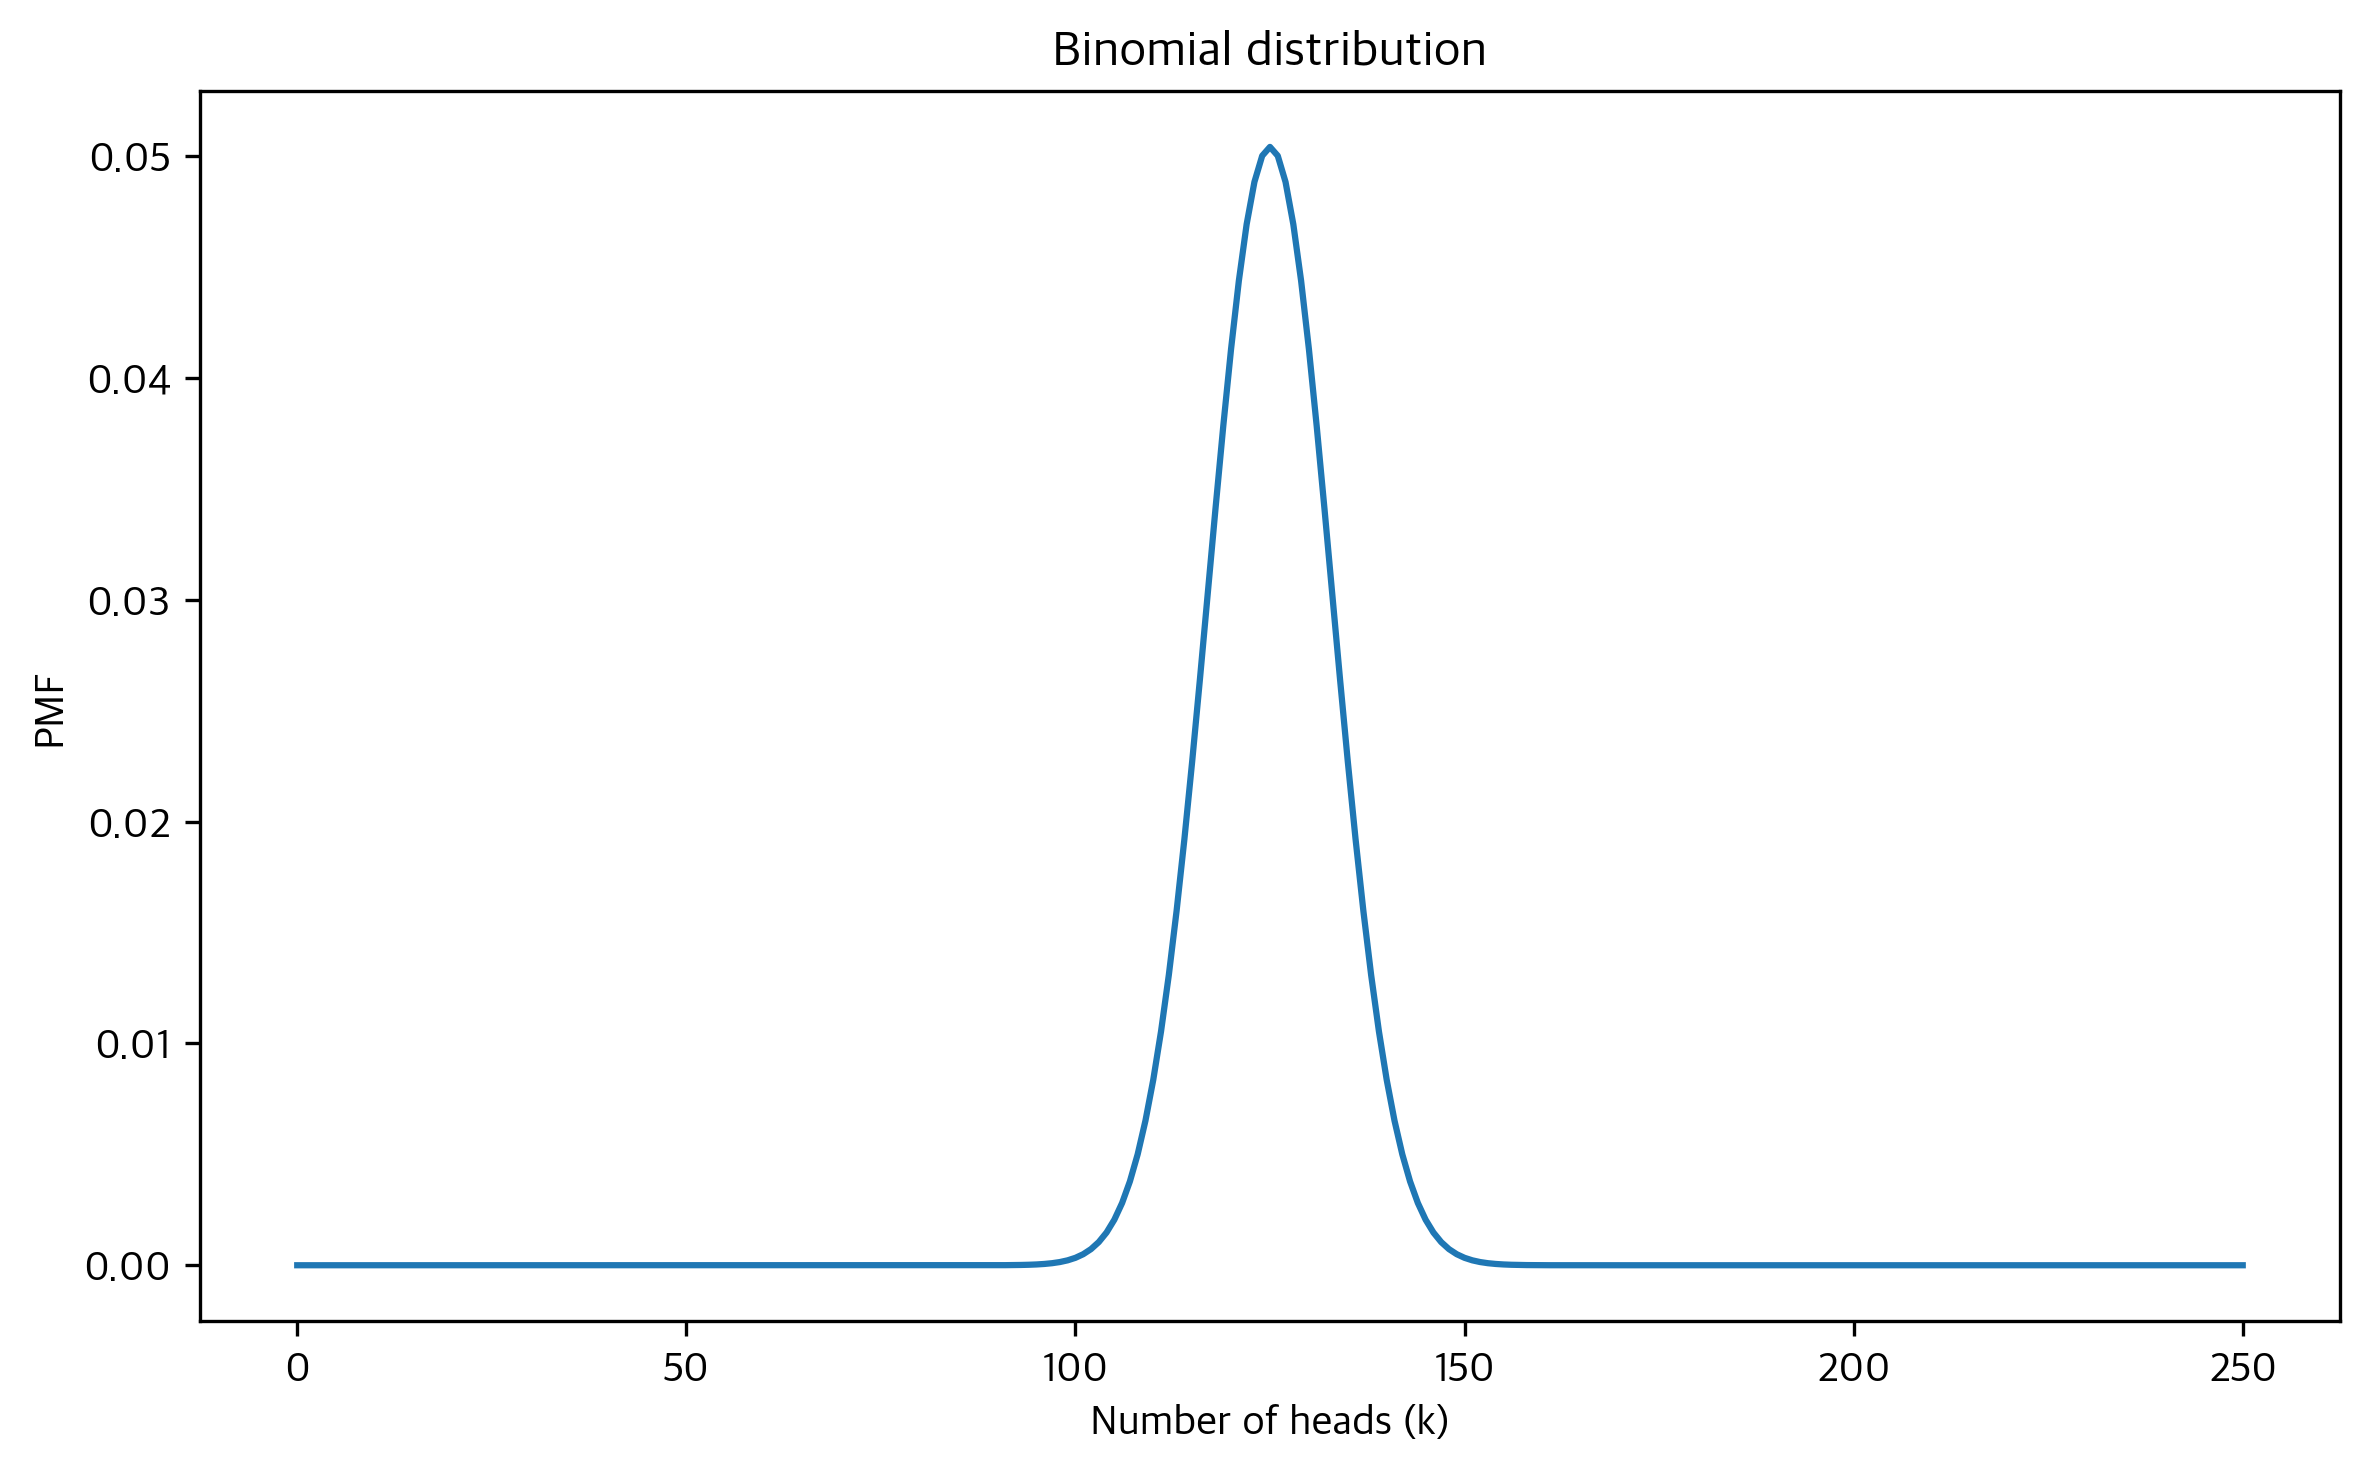

In [8]:
from utils import decorate

pmf_k.plot(layout='n=250, p=0.5')

decorate(xlabel='Number of heads (k)',
         ylabel='PMF',
         title='Binomial distribution')

In [9]:
pmf_k.max_prob()

125

125일때 최대값이고 이때 확률은 약 5%

In [10]:
pmf_k[125]

0.050412213147309655

MacKay 예에서 140일때 확률은 더 낮음

In [11]:
pmf_k[140]

0.008357181724918188

MacKay가 인용한 기사에서 통계학자는 "만약 동전이 편향되지 않았다면, 그런 극단적인 결과를 얻을 확률이 7% 미만일 것이다."라고 말합니다.

우리는 이항 분포를 사용하여 그의 계산을 확인할 수 있습니다. 다음 함수는 PMF(확률 질량 함수)를 받아 threshold 이상인 수량의 총 확률을 계산합니다.

In [12]:
def prob_ge(pmf, threshold):
    """Probability of quantities greater than threshold."""
    ge = (pmf.qs >= threshold)
    total = pmf[ge].sum()
    return total

140개이상의 앞면의 확률은

In [13]:
prob_ge(pmf_k, 140)

0.03321057562002166

In [14]:
pmf_k.prob_ge(140)

0.03321057562002166

결과는 약 3.3%로, 인용된 7%보다 낮습니다. 차이의 이유는 통계학자가 140과 "같은 정도로 극단적인" 모든 결과를 포함하기 때문이며, 이에는 110 이하의 결과도 포함됩니다.

그 근거를 알기 위해, 기대되는 앞면의 수가 125라는 것을 기억해야 합니다. 만약 우리가 140을 얻었다면, 그 기대치를 15만큼 초과한 것입니다.
그리고 만약 우리가 110을 얻었다면, 15만큼 못 미친 것입니다.

7%는 이러한 두 "꼬리"의 합계이며, 다음 그림에서 보여지듯이 나타납니다.

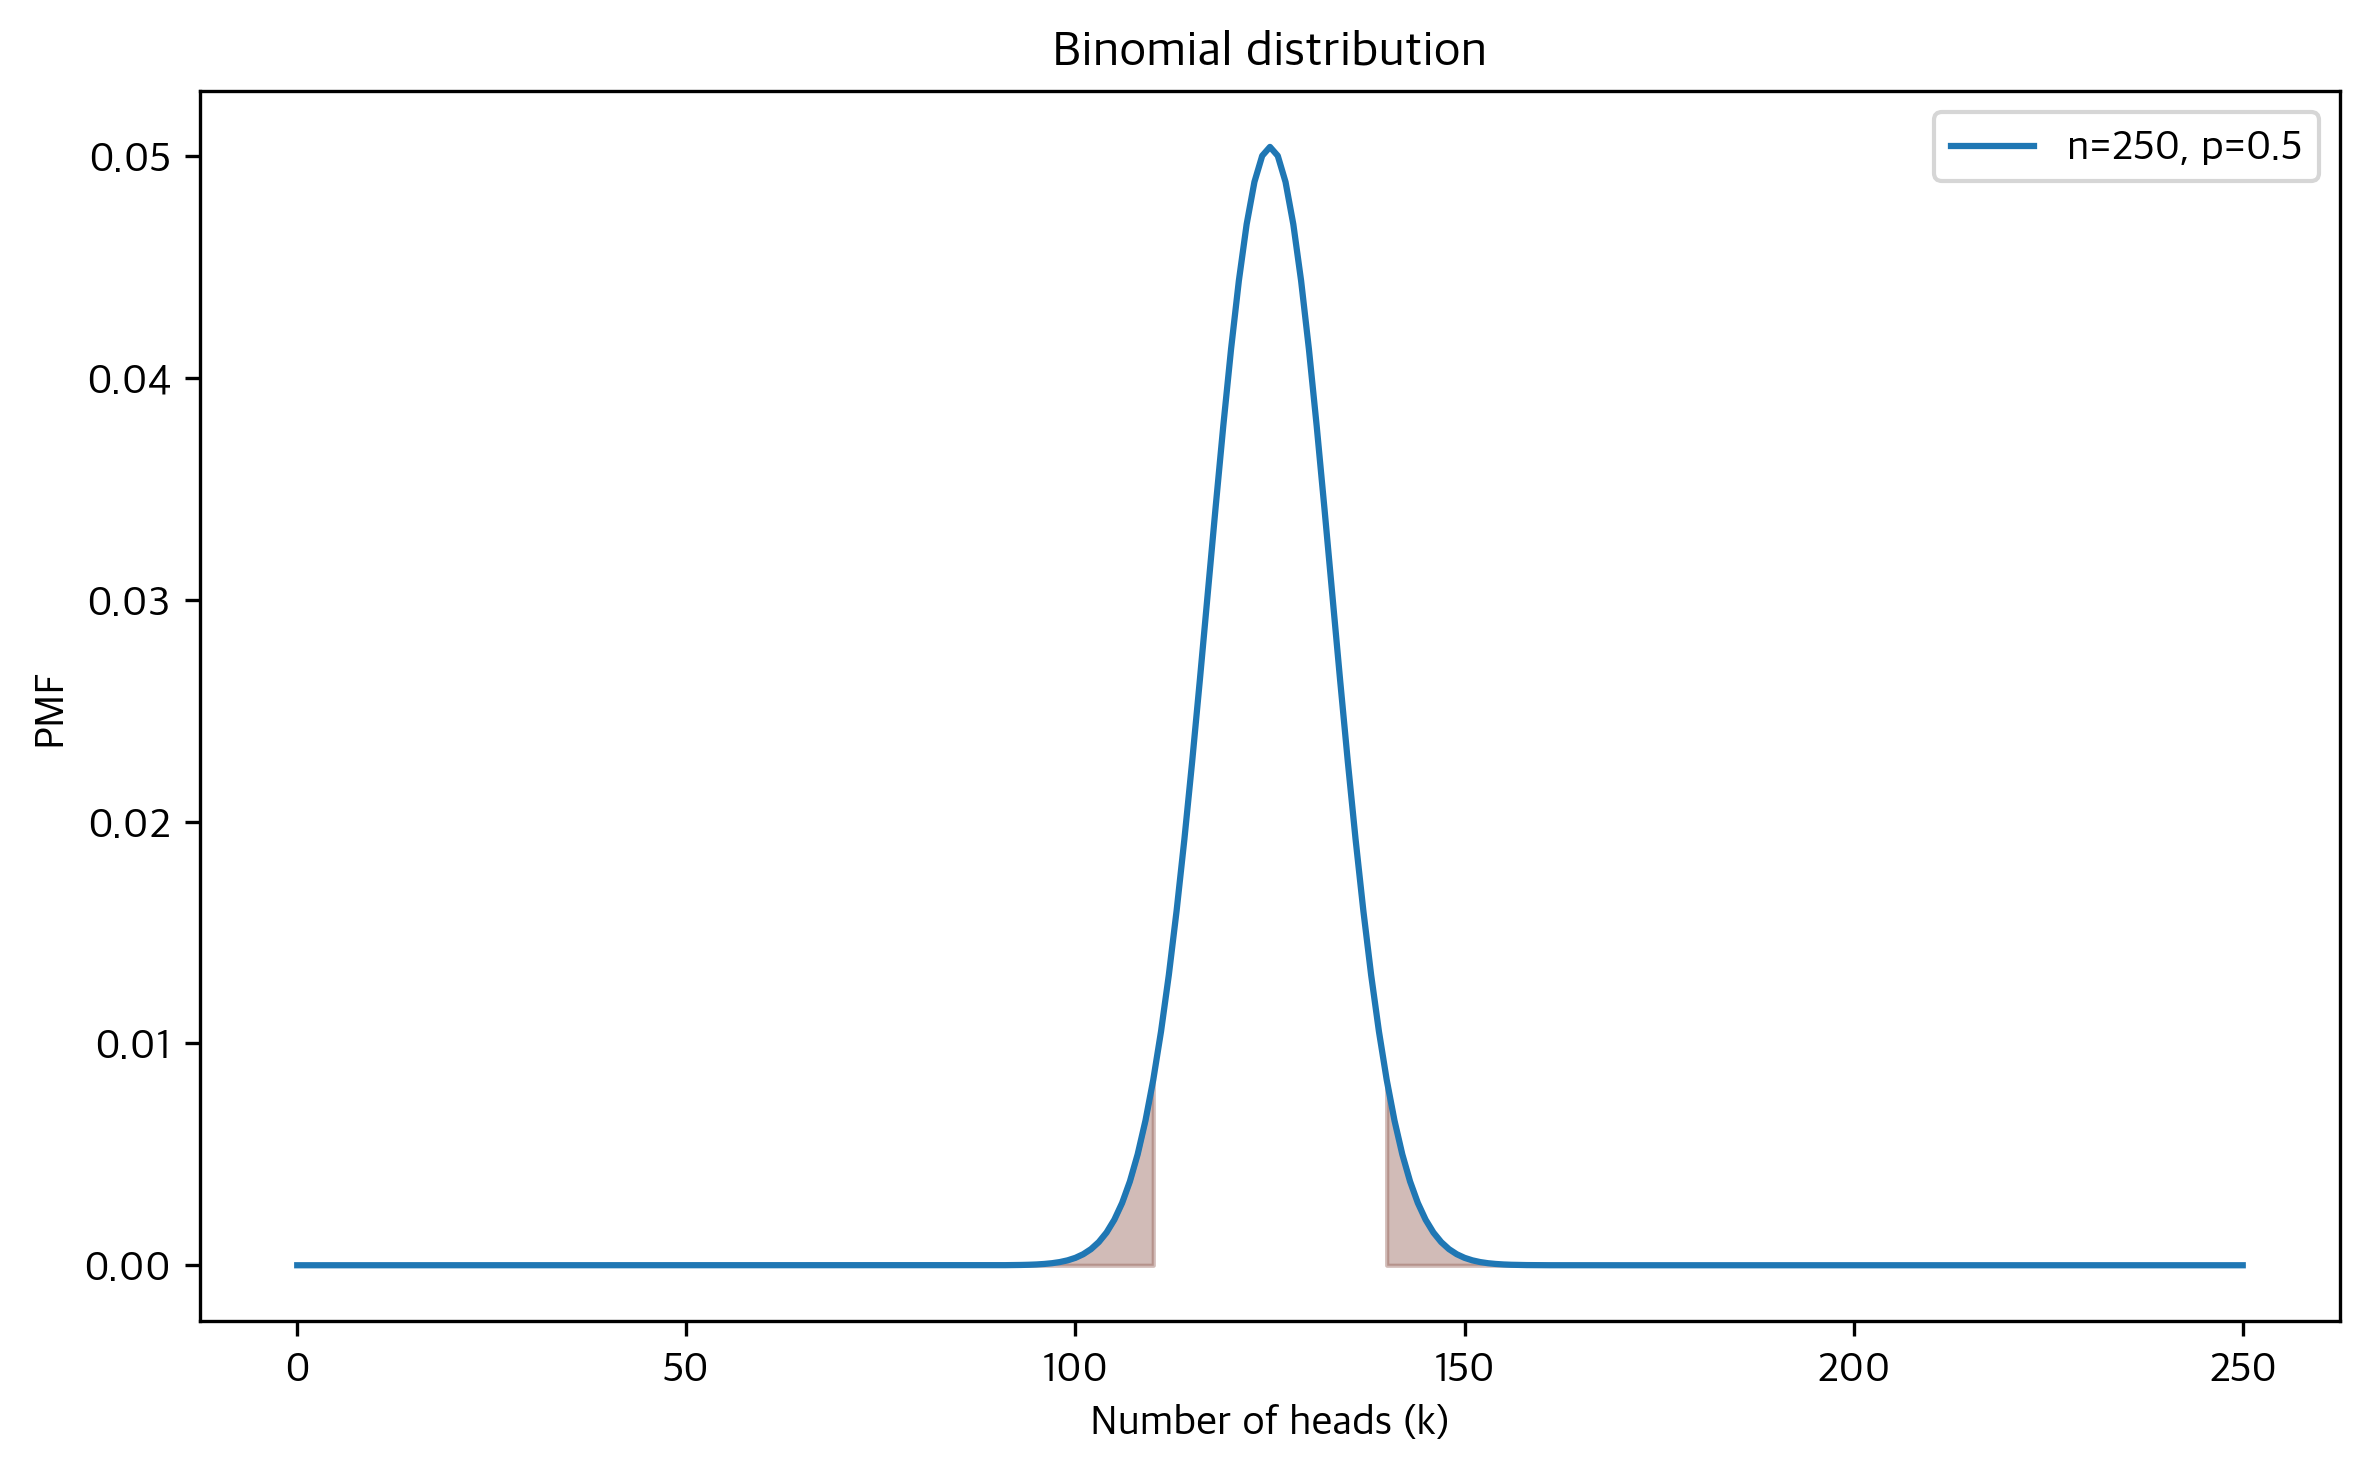

In [15]:
import matplotlib.pyplot as plt

def fill_below(pmf):
    qs = pmf.index
    ps = pmf.values
    plt.fill_between(qs, ps, 0, color='C5', alpha=0.4)

qs = pmf_k.index
fill_below(pmf_k[qs>=140])
fill_below(pmf_k[qs<=110])
pmf_k.plot(label='n=250, p=0.5')

decorate(xlabel='Number of heads (k)',
         ylabel='PMF',
         title='Binomial distribution')

110보다 작은 앞면의 확률을 계산해보면

In [16]:
pmf_k.prob_le(110)

0.033210575620021665

110 이하의 결과의 확률도 3.3%이므로, 140만큼 "극단적인" 결과의 총 확률은 6.6%입니다.

이 계산의 요점은 동전이 공정하다면 이러한 극단적인 결과는 발생할 가능성이 낮다는 것입니다.

이것은 흥미롭지만, MacKay의 질문에는 답을 하지 않습니다. 우리가 답을 찾을 수 있을지 살펴보겠습니다.

## 베이지안 추정

어떤 주어진 동전이 가장자리에 세워져 돌릴 때 앞면이 나올 확률이 있습니다; 이 확률을 `x`라고 하겠습니다.
`x`는 동전의 물리적 특성, 예를 들어 무게 분포에 따라 달라질 것 같다는 가정이 합리적입니다.
만약 동전이 완벽하게 균형 잡혀 있다면 `x`는 50%에 가까울 것으로 기대하지만, 한쪽으로 치우친 동전이라면 `x`는 상당히 다를 수 있습니다.
우리는 베이즈 정리와 관찰된 데이터를 사용해서 `x`를 추정할 수 있습니다.

단순화를 위해서, 모든 `x`의 값이 동등하게 가능하다고 가정하는 균등 사전 확률로 시작하겠습니다.
이것이 합리적인 가정이 아닐 수 있기 때문에, 나중에 다른 사전 확률을 고려해 볼 것입니다.

균등 사전 확률을 이렇게 만들 수 있습니다:


In [17]:
hypos = np.linspace(0, 1, 101)
hypos


array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99, 1.  ])

In [18]:
prior = Pmf(1, hypos)
prior

,probs
0.00,1
0.01,1
0.02,1
0.03,1
0.04,1
...,...
0.96,1
0.97,1
0.98,1
0.99,1


In [19]:
likelihood_heads = hypos
likelihood_tails = 1 - hypos

In [20]:
likelihood = {
    'H': likelihood_heads,
    'T': likelihood_tails
}

In [21]:
dataset = 'H' * 140 + 'T' * 110
dataset

'HHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT'

In [22]:
def update_euro(pmf, dataset):
    for data in dataset:
        pmf *= likelihood[data]
    pmf.normalize()

첫 번째 인자는 사전 확률을 나타내는 `Pmf`입니다.
두 번째 인자는 문자열의 시퀀스입니다.
루프를 돌 때마다, 우리는 `pmf`를 한 결과의 가능성인 `H` 또는 `T`에 대한 `pmf`를 곱합니다.

`normalize`가 루프 밖에 있다는 점에 주목해야 합니다, 그래서 사후 확률 분포는 오직 한 번, 마지막에 정규화됩니다.
이것은 각 스핀 후에 정규화하는 것보다 더 효율적입니다 (비록 우리가 나중에 볼 것이지만, 이것은 부동소수점 연산으로 인한 문제를 일으킬 수도 있습니다).

`update_euro`를 사용하는 방법은 다음과 같습니다.


In [23]:
posterior = prior.copy()
update_euro(posterior, dataset)
posterior

,probs
0.00,0.000000e+00
0.01,1.256330e-207
0.02,5.731921e-166
0.03,8.338711e-142
0.04,8.269265e-125
...,...
0.96,2.107677e-83
0.97,1.624102e-96
0.98,2.911941e-115
0.99,9.293081e-148


In [24]:
def decorate_euro(title):
    decorate(xlabel='Proportion of heads (x)',
             ylabel='Probability',
             title=title)

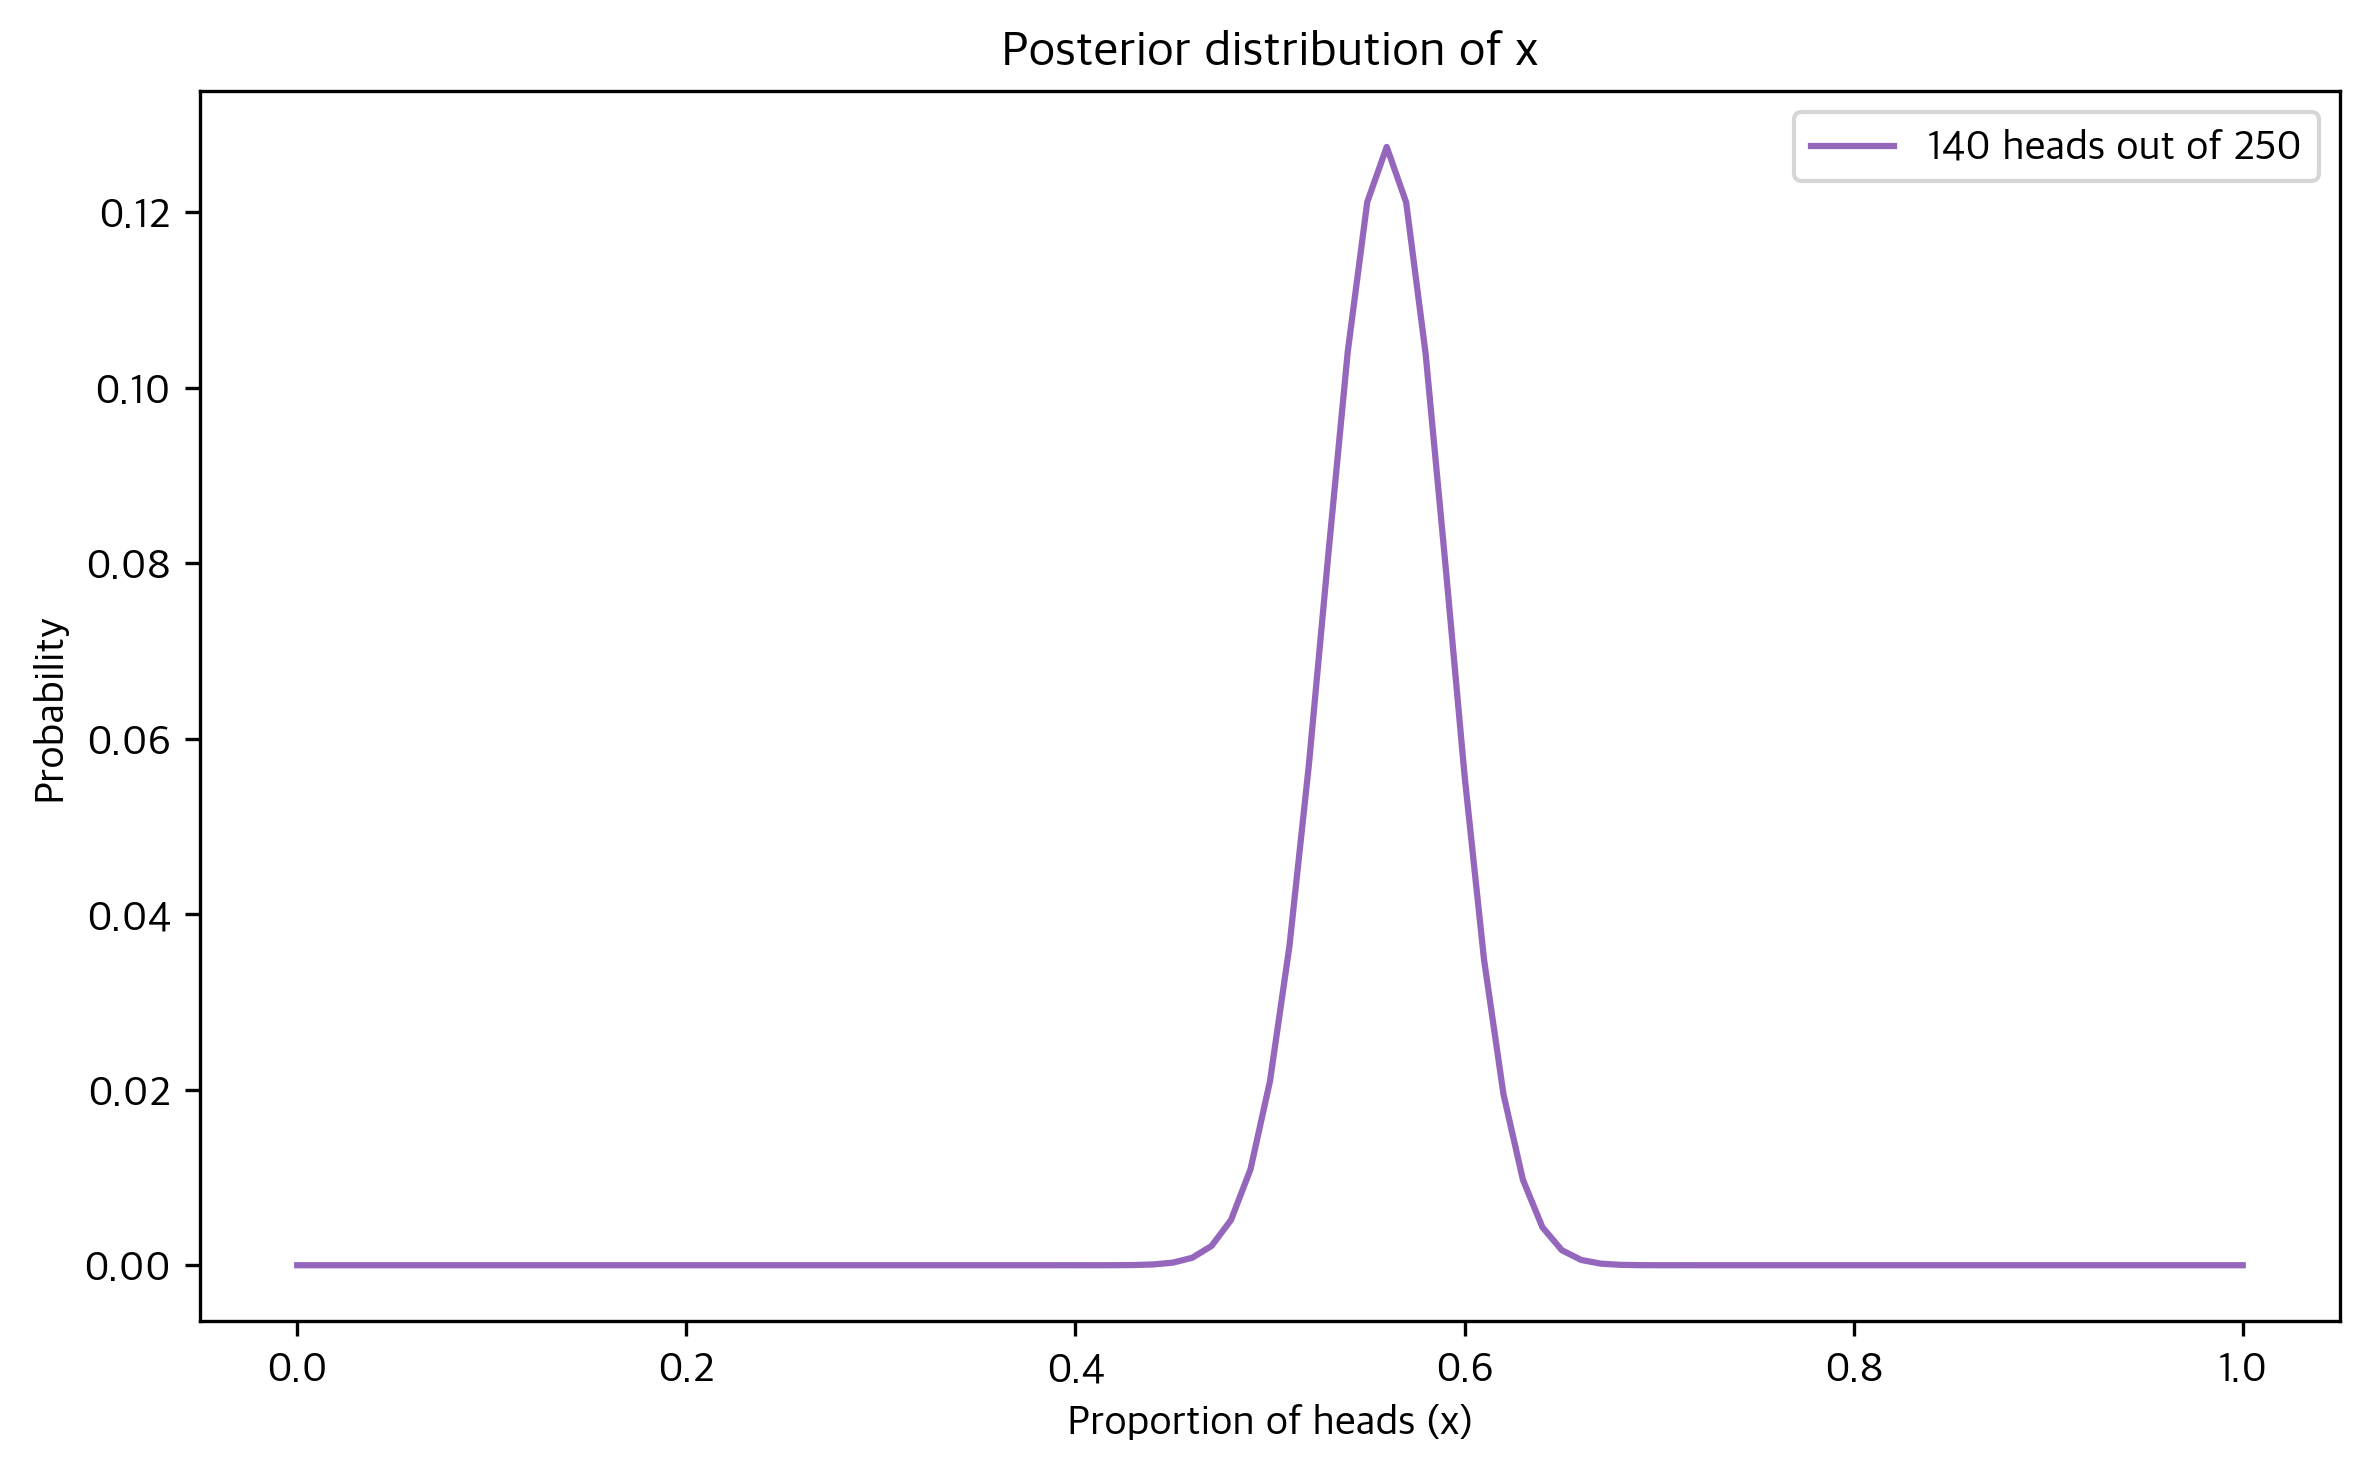

In [25]:
posterior.plot(label='140 heads out of 250', color='C4')
decorate_euro(title='Posterior distribution of x')

이 그림은 우리가 관찰한 동전에 대한 앞면의 비율인 `x`의 사후 분포를 보여줍니다.

사후 분포는 데이터를 본 후 `x`에 대한 우리의 믿음을 나타냅니다.
이는 0.4 미만과 0.7 초과의 값이 가능성이 낮다는 것을 나타내고; 0.5와 0.6 사이의 값이 가장 가능성이 높습니다.

사실, `x`에 대한 가장 가능성 높은 값은 데이터셋에서 앞면의 비율인 `140/250`인 0.56입니다.


In [26]:
posterior.max_prob()

0.56

## Triangle Prior
지금까지 우리는 uniform prior를 사용했습니다.

In [27]:
uniform = Pmf(1, hypos, name='uniform')
uniform.normalize()


101

하지만 우리가 동전에 대해 알고 있는 것을 바탕으로 할 때, 그것이 합리적인 선택일 수는 없습니다.
만약 동전이 한쪽으로 치우쳐 있다면, `x`가 0.5에서 상당히 벗어날 수 있다고 생각할 수 있지만, 벨기에 유로 동전이 `x`가 0.1이나 0.9처럼 매우 불균형하다는 것은 별로 가능성이 없어 보입니다.

0.5에 가까운 `x` 값에 더 높은 확률을 주고 극단적인 값에는 더 낮은 확률을 주는 사전 확률을 선택하는 것이 더 합리적일 수 있습니다.

예를 들어, 삼각형 모양의 사전 확률을 시도해 보겠습니다.
이 코드는 그것을 구성하는 방법입니다:


In [28]:
ramp_up = np.arange(50)
ramp_down = np.arange(50, -1, -1)

a = np.append(ramp_up, ramp_down)

triangle = Pmf(a, hypos, name='triangle')
triangle.normalize()


2500

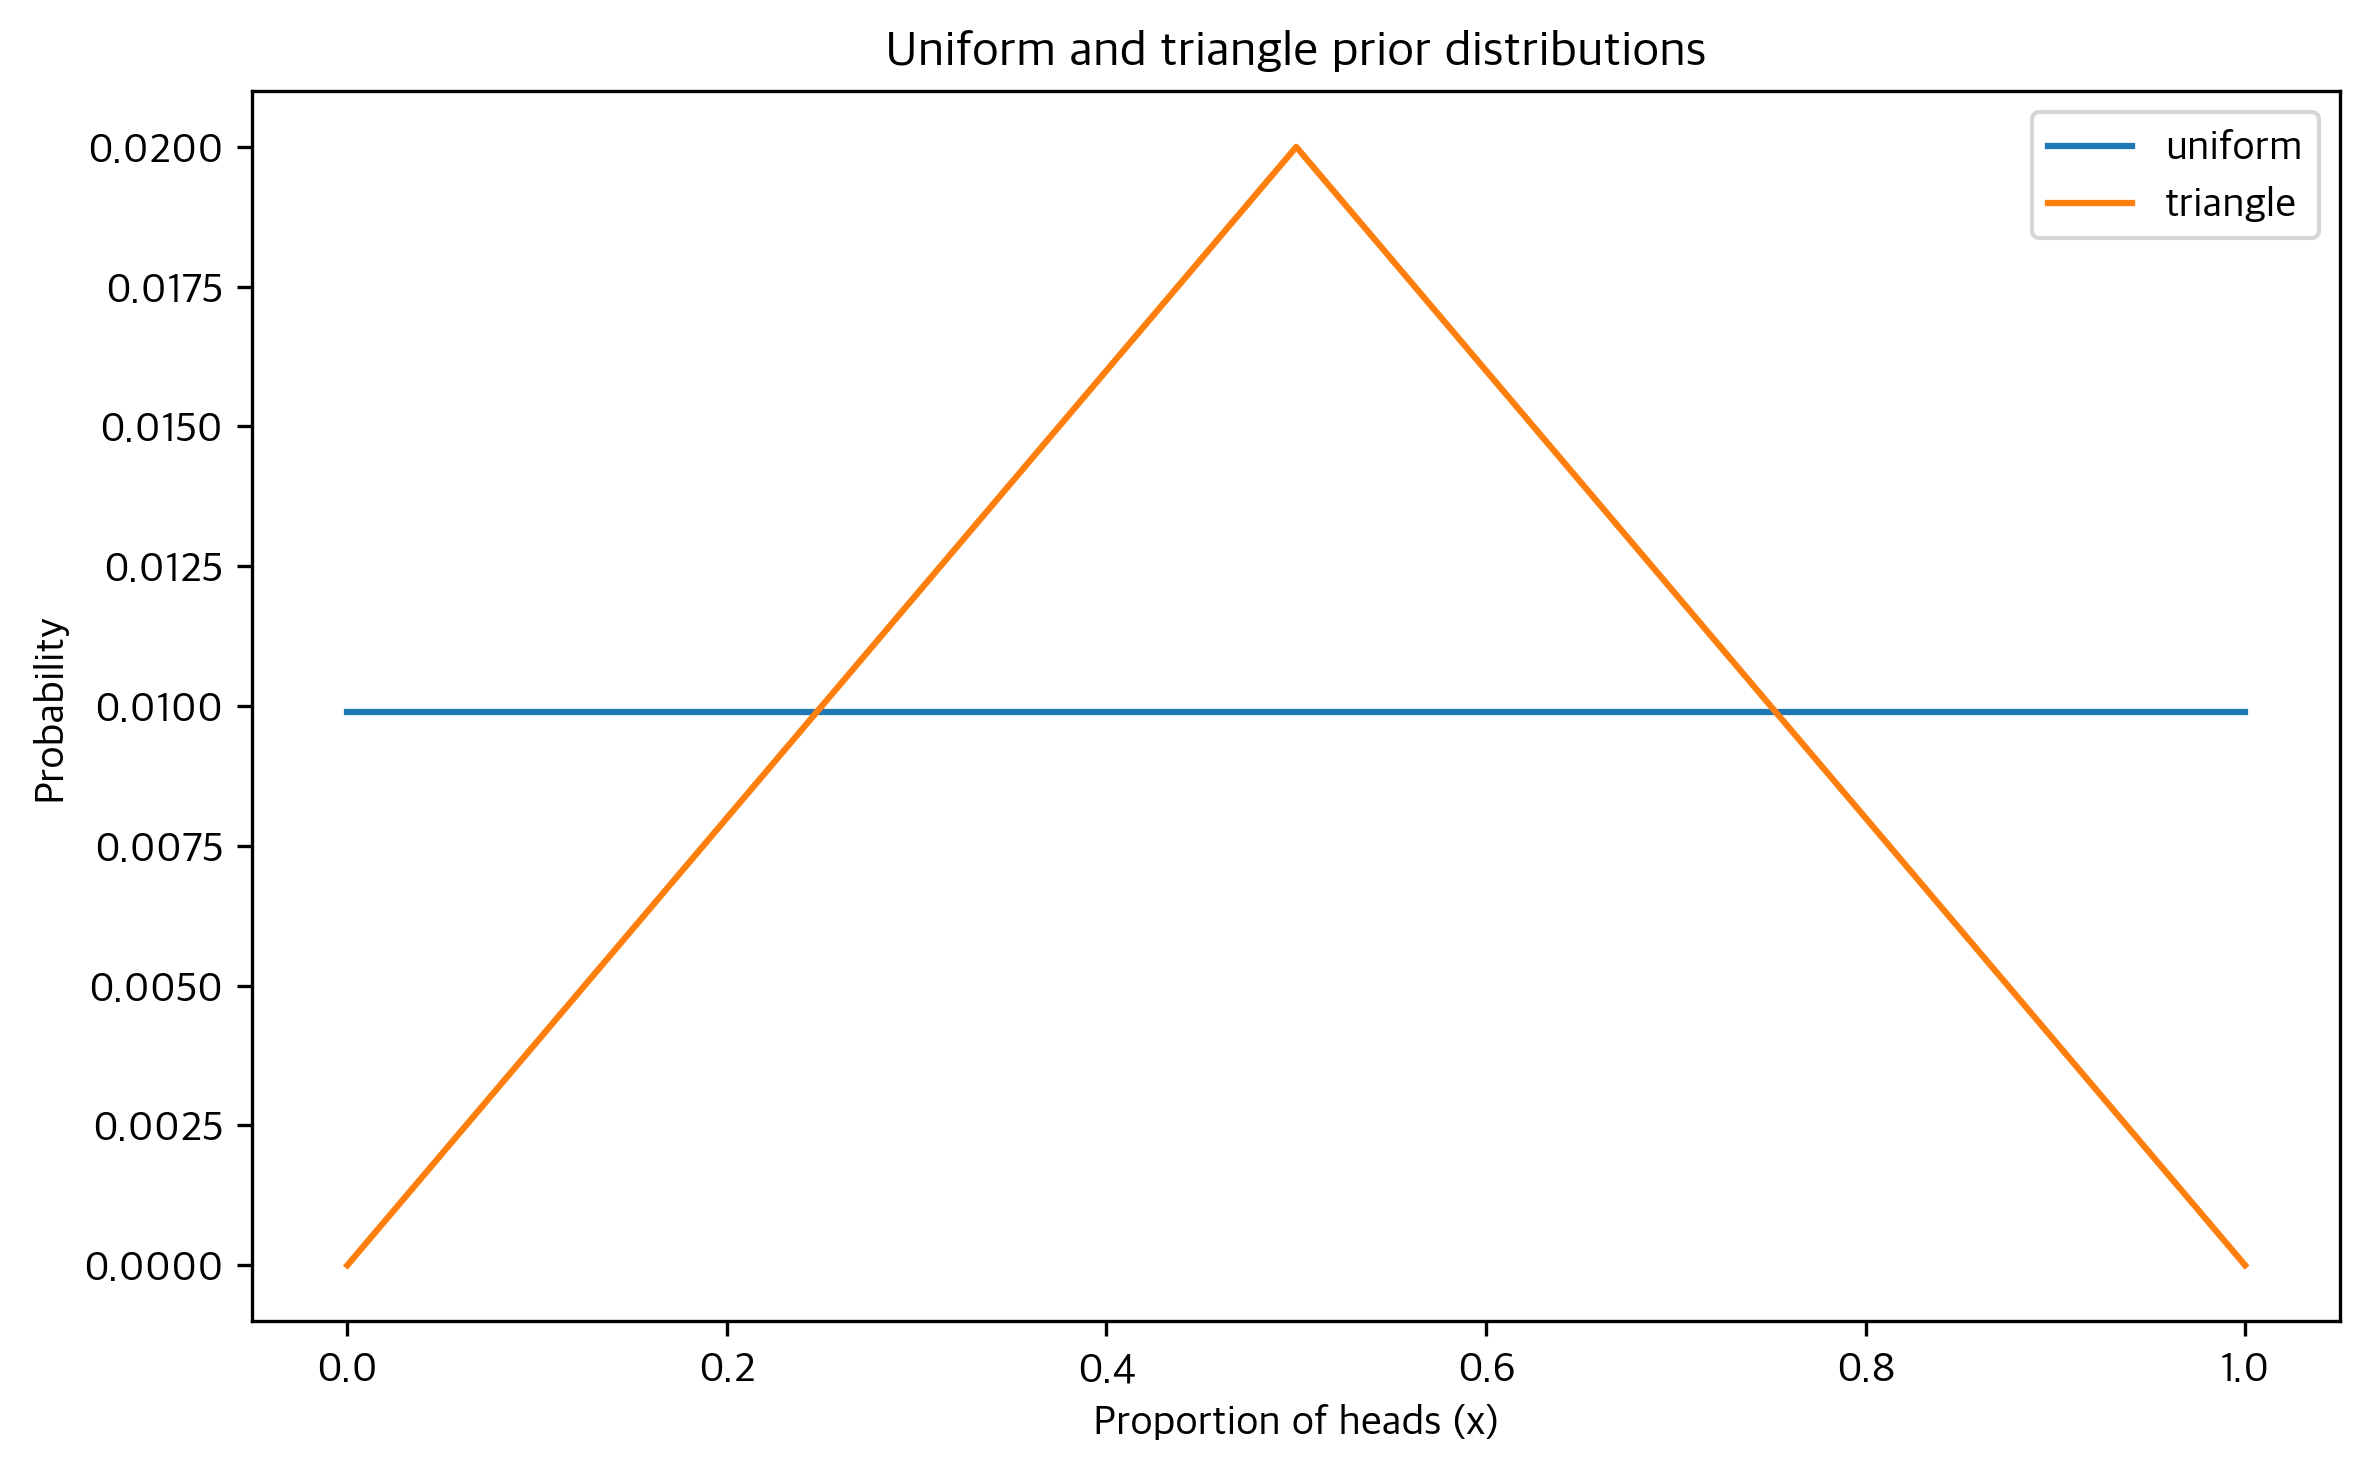

In [29]:
uniform.plot()
triangle.plot()
decorate_euro(title='Uniform and triangle prior distributions')

In [30]:
update_euro(uniform, dataset)
update_euro(triangle, dataset)

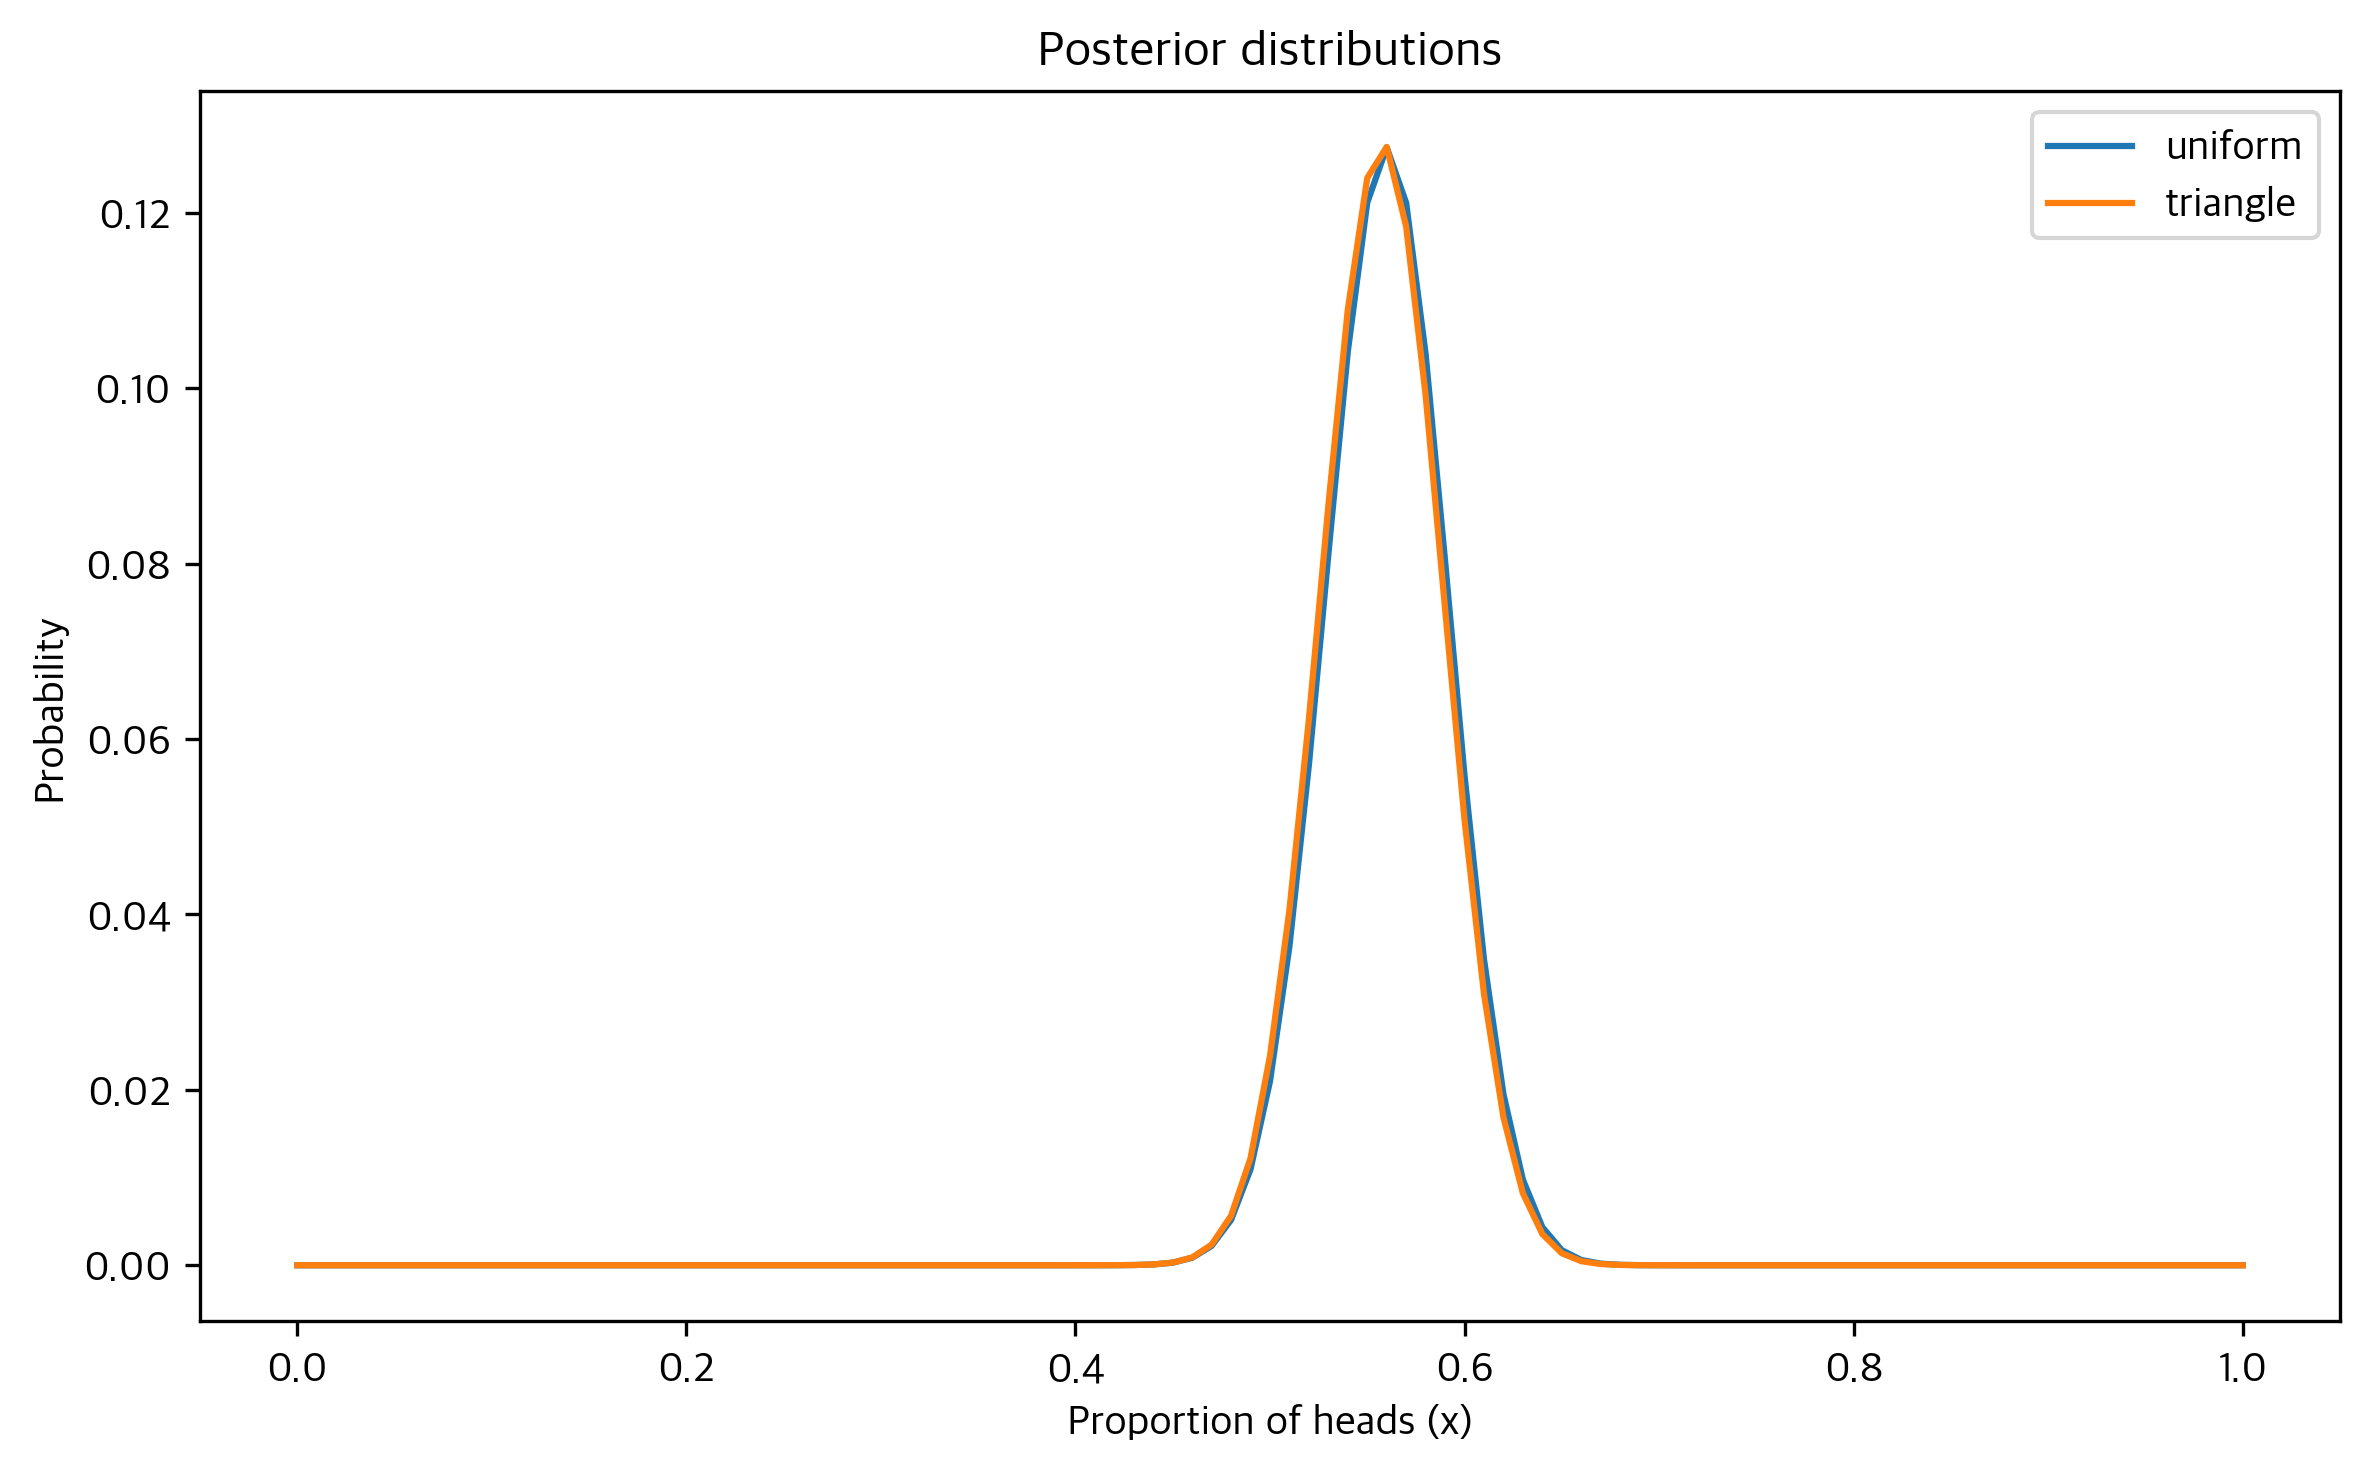

In [31]:
uniform.plot()
triangle.plot()
decorate_euro(title='Posterior distributions')

사후 분포 사이의 차이는 거의 보이지 않으며, 실제로 미미할 정도로 작습니다.

그리고 이것은 좋은 소식입니다.
왜냐하면, 상반된 사전 확률을 두고 격렬하게 의견이 다른 두 사람을 상상해 보십시오. 균등 분포가 더 나은지, 삼각형 분포가 더 나은지에 대해. 각자 자신의 선호에 대한 이유가 있지만, 어느 쪽도 상대방의 마음을 바꾸도록 설득할 수는 없습니다.

그러나 그들이 데이터를 사용하여 자신의 믿음을 업데이트하기로 동의한다고 가정해 봅시다.
그들이 자신의 사후 분포를 비교했을 때, 논쟁할 것이 거의 남아 있지 않다는 것을 발견합니다.

이것은 **사전 확률의 홍수** (**swamping the priors**)의 한 예입니다: 충분한 데이터가 있으면, 다른 사전 확률로 시작한 사람들은 같은 사후 분포로 수렴하게 될 것입니다.


## 이항 확률 함수(The Binomial Likelihood Function)

지금까지 우리는 한 번의 스핀을 한 번에 업데이트하며 계산해 왔으므로, 유로 문제에 대해 250번의 업데이트를 해야 했습니다.

보다 효율적인 대안은 전체 데이터셋의 가능성을 한 번에 계산하는 것입니다.
`x`의 가설적인 값 각각에 대해, 250번의 스핀 중 140번 앞면이 나올 확률을 계산해야 합니다.

이것은 바로 이항 분포가 답하는 질문입니다; 앞면의 확률이 $p$일 때, $n$번의 스핀에서 $k$번 앞면이 나올 확률은:

$$\binom{n}{k} p^k (1-p)^{n-k}$$

이고, 우리는 SciPy를 사용하여 이것을 계산할 수 있습니다.
다음 함수는 사전 분포를 나타내는 `Pmf`와 데이터를 나타내는 정수의 튜플을 받습니다:


In [32]:
from scipy.stats import binom

def update_binomial(pmf, data):
    """Update the PMF using the binomial distribution."""
    k, n = data
    xs = pmf.qs
    likelihood = binom.pmf(k, n, xs)
    pmf *= likelihood
    pmf.normalize()

data는 k, n 튜플

In [33]:
uniform2 = Pmf(1, hypos, name='uniform2')
data = 140, 250
update_binomial(uniform2, data)

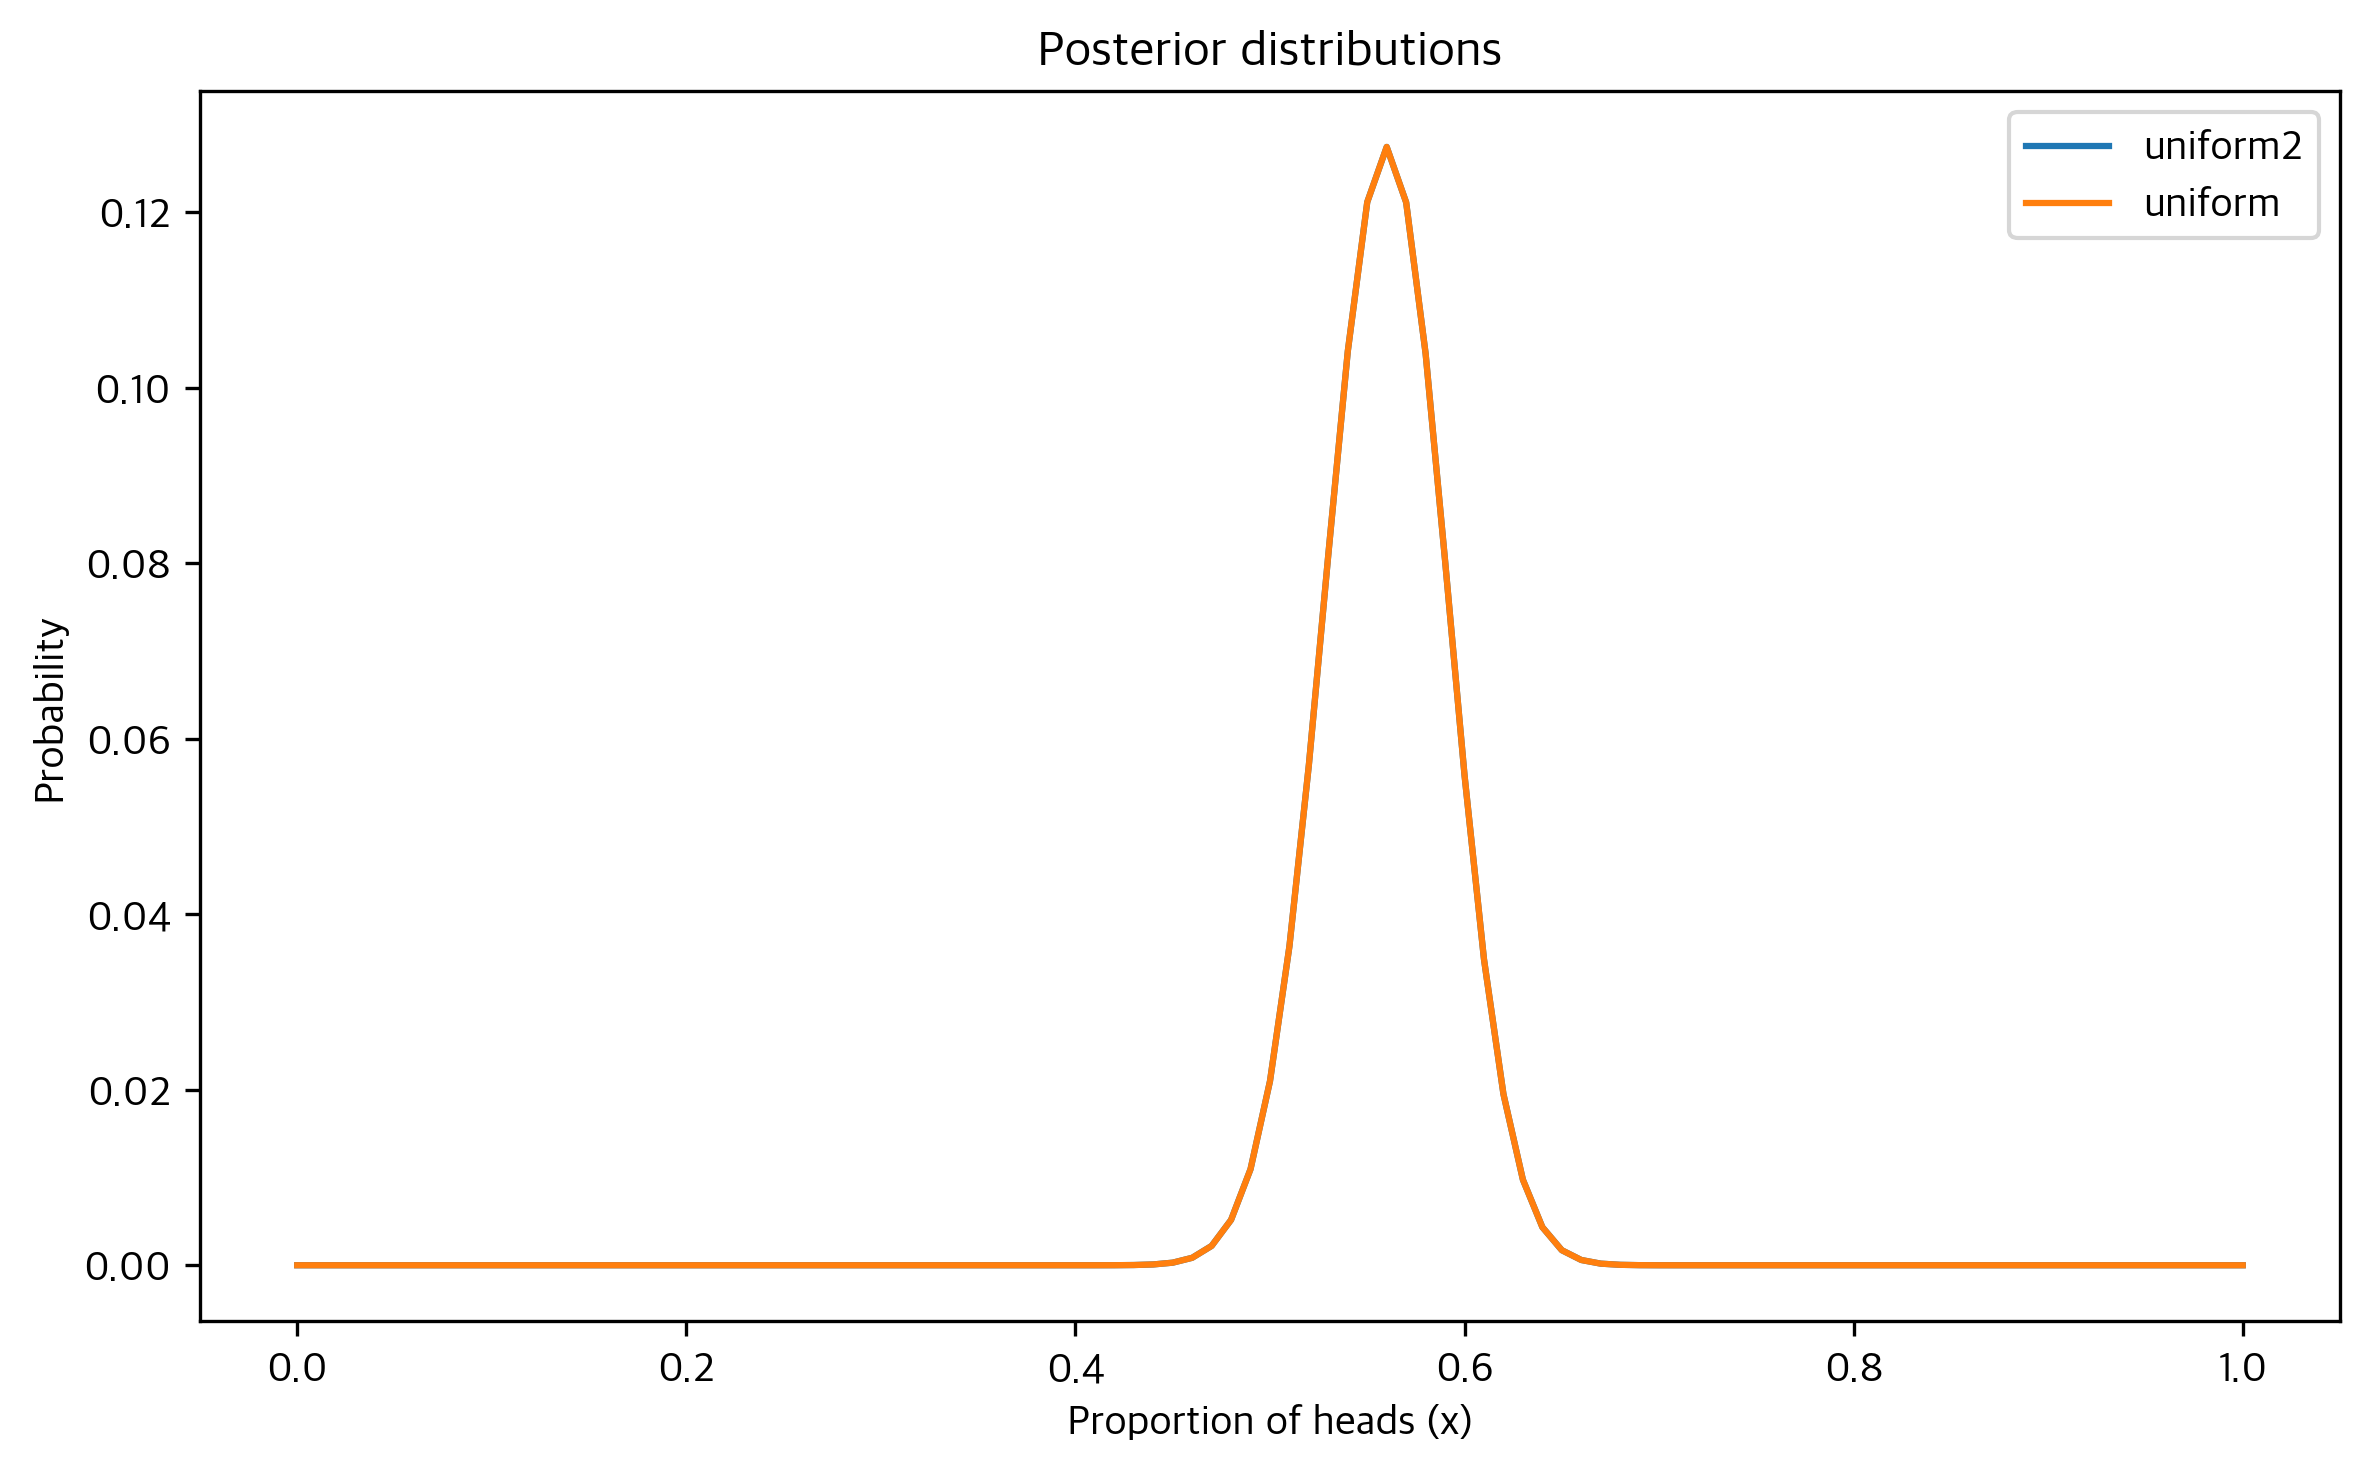

In [34]:
uniform2.plot()
uniform.plot()
decorate_euro(title='Posterior distributions')

`allclose` 함수를 사용하여 결과가 이전 섹션과 동일하다는 것을 확인할 수 있습니다. 단, 소수점 반올림으로 인한 작은 차이는 있을 수 있습니다.

In [35]:
np.allclose(uniform, uniform2)

True

하지만 이런 방식의 계산은 훨씬 효율적입니다.

## 베이지안 통계학

여러분은 유로 문제와 101 그릇 문제 사이의 유사점을 눈치챘을 것입니다.
사전 분포는 같고, 가능성(likelihood)도 같으며, 같은 데이터를 가지고 있다면 결과도 같을 것입니다.
하지만 두 가지 차이점이 있습니다.

첫 번째는 사전 확률의 선택입니다.
101 그릇 문제에서, 균등 사전 확률은 문제의 서술에 의해 암시되며, 이는 우리가 동등한 확률로 그릇 중 하나를 무작위로 선택한다고 말합니다.

유로 문제에서, 사전 확률의 선택은 주관적입니다; 즉, 합리적인 사람들이 동전에 대한 다른 정보를 가지고 있거나 같은 정보를 다르게 해석하기 때문에 의견이 다를 수 있습니다.

사전 확률이 주관적이기 때문에, 사후 확률도 주관적입니다.
그리고 일부 사람들은 이것이 문제가 있다고 생각합니다.


다른 차이점은 우리가 추정하고 있는 것의 성격입니다.
101 그릇 문제에서, 우리는 그릇을 무작위로 선택하므로, 각 그릇을 선택할 확률을 계산하는 것은 논란의 여지가 없습니다.
유로 문제에서, 앞면의 비율은 주어진 동전의 물리적 성질입니다.
확률의 일부 해석하에는, 물리적 성질은 무작위로 간주되지 않기 때문에 이것이 문제가 됩니다.

예를 들어, 우주의 나이를 고려해 보십시오.
현재, 우리의 최고 추정치는 138억 년이지만, 양 방향으로 0.02억 년 정도 차이가 날 수 있습니다([여기](https://en.wikipedia.org/wiki/Age_of_the_universe) 참조).

현재 과학자들은 우주의 나이를 약 138억 년으로 추정하고 있으며, 이 추정치는 대략 0.02억 년의 오차 범위를 가집니다. 이는 관측 데이터와 우주론 모델을 바탕으로 한 최선의 추정치입니다.

이제 "우주의 나이가 실제로 138.1억 년보다 클 확률은 얼마인가?"라는 질문에 대해 생각해 봅시다. 확률의 전통적인 빈도주의 해석에서는, 우주의 나이와 같은 물리적 상수는 변하지 않는 고정된 값으로 간주됩니다. 따라서, 이러한 해석에서는 우주의 나이가 특정 값보다 크거나 작다는 것에 확률을 할당하는 것은 불가능하거나 의미가 없다고 여겨집니다. 이 관점에서는, 우주의 나이는 단순히 알아내야 할 하나의 값이며, 이 값 자체에 대해 확률을 말하는 것은 논리적으로 맞지 않습니다.

반면에, 베이지안 확률 해석은 확률을 믿음의 정도나 불확실성의 표현으로 보고, 이를 통해 물리적 성질에 대해서도 확률을 할당하는 것을 가능하게 합니다. 이 관점에서 확률은 물리적 성질 자체보다는 우리의 지식이나 정보에 대한 것입니다. 따라서 우주의 나이가 138.1억 년보다 클 확률을 계산하는 것은, 주어진 증거와 우리의 믿음을 바탕으로 우주의 나이에 대한 불확실성을 수량화하는 방법으로 이해될 수 있습니다.

베이지안 접근 방식을 사용함으로써, 우리는 관측된 데이터와 우리가 가지고 있는 사전 지식을 결합하여 우주의 나이에 대한 사후 확률 분포를 형성할 수 있습니다. 이 분포는 우리가 우주의 나이에 대해 얼마나 확신하는지, 그리고 그 값이 특정 범위 내에 있을 가능성이 얼마나 되는지를 보여줍니다. 따라서, 우주의 나이가 138.1억 년보다 클 확률을 계산하는 것은 물리적 성질에 대한 우리의 불확실성을 정량적으로 평가하는 유용한 방법이 됩니다.

사전 확률의 주관성과 사후 확률의 해석은 베이즈 정리를 사용하고 베이지안 통계학을 수행하는 것 사이의 핵심적인 차이점입니다.

베이즈 정리는 확률의 수학적 법칙입니다; 합리적인 사람이라면 이에 이의를 제기하지 않습니다.
그러나 베이지안 통계학은 놀랍게도 논란의 여지가 있습니다.
역사적으로, 많은 사람들이 그것의 주관성과 무작위가 아닌 것들에 대한 확률 사용에 문제를 제기해왔습니다.

이 역사에 관심이 있다면, 샤론 버치 맥그레인의 책 *[The Theory That Would Not Die](https://yalebooks.yale.edu/book/9780300188226/theory-would-not-die)*를 추천합니다.


### 베이즈 정리와 베이지안 통계학의 차이

#### 베이즈 정리
베이즈 정리는 조건부 확률에 관한 수학적 법칙으로, 어떤 사건 B가 발생했다는 조건 하에 사건 A가 발생할 확률을 계산하는 방법을 제공합니다. 이 정리는 확률론의 기본적인 부분으로, 그 자체로는 논란의 여지가 없습니다.

#### 베이지안 통계학
베이지안 통계학은 베이즈 정리를 기반으로 하지만, 사전 확률과 같은 개념을 통해 불확실성을 수량화하는 방법론입니다. 이는 실험 이전의 믿음이나 지식을 반영하며, 주관적일 수 있습니다. 사람들이 다른 사전 지식을 가지고 있기 때문에, 동일한 데이터를 바탕으로 하더라도 다른 사후 확률을 도출할 수 있습니다.

#### 주관성과 논란
베이지안 통계학의 주관성은 빈도주의 통계학과의 차이점이자 논란의 원인입니다. 베이지안 접근법은 사전 지식을 확률 계산에 명시적으로 포함시키며, 고정된 값을 가진 물리적 성질에 대해서도 확률을 할당할 수 있습니다.

#### 역사적 맥락
샤론 버치 맥그레인의 책 "The Theory That Would Not Die"는 베이지안 통계학의 역사와 이와 관련된 논쟁, 그리고 이 이론이 현대 과학과 의사결정 과정에서 어떻게 중요한 역할을 하게 되었는지를 탐구합니다. 이 책은 베이지안 통계학의 배경과 학문적, 철학적 도전을 이해하는 데 유용합니다.

베이지안 통계학은 데이터 분석과 의사결정 과정에서 불확실성을 수량화하는 방법론으로, 그 주관성과 적용 범위에 대한 논의는 계속되고 있습니다.


## 요약

이 장에서는 David MacKay의 유로 문제를 제기하고 해결하기 시작했습니다.
주어진 데이터를 바탕으로, 우리는 유로 동전이 앞면이 나올 확률 `x`에 대한 사후 분포를 계산했습니다.

우리는 두 가지 다른 사전 확률을 시도하고, 같은 데이터로 업데이트한 후, 사후 확률이 거의 같다는 것을 발견했습니다.
이것은 좋은 소식입니다, 왜냐하면 만약 두 사람이 다른 믿음으로 시작하고 같은 데이터를 보게 된다면, 그들의 믿음이 수렴하게 된다는 것을 제안하기 때문입니다.

이 장에서는 사후 분포를 더 효율적으로 계산하기 위해 사용한 이항 분포를 소개했습니다.
그리고 101 그릇 문제에서 베이즈 정리를 적용하는 것과 유로 문제에서 베이지안 통계학을 수행하는 것 사이의 차이점에 대해 논의했습니다.

그러나 우리는 아직 MacKay의 질문에 답하지 않았습니다: "이 데이터는 동전이 공정하기보다는 편향되었다는 증거를 제공하는가?"
이 질문을 조금 더 매달아 두겠습니다; 우리는 <<_Testing>>에서 다시 이 질문으로 돌아올 것입니다.

다음 장에서는, 기차, 탱크, 그리고 토끼와 관련된 계산 문제를 해결할 것입니다.

그러나 먼저 이 연습문제에 도전해 보세요.


## 연습 문제